In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

abtem.config.set({"local_diagnostics.progress_bar": True});

(walkthrough:frozen_phonons)= 
# Frozen phonons

The atoms in real materials are not stationary, they vibrate around their position in the crystal due to thermal and zero-point vibrations. 

Vibrational scattering (or electron-phonon scattering) is responsible for features including diffuse backgrounds and Kikuchi lines as well as for a significant part of the high-angle scattering measured in annular dark-field measurements.

The frozen phonon model is a simple, if brute, approach to simulate the effects of phonons on electron scattering. Nonetheless, the frozen phonons model has been shown to produce the same result as models with better theoretical foundation from quantum mechanics {cite}`forbes_qep`{cite}`van_dyck_frozen_phonons`. In the Frozen phonon approximation, the intensity is averaged over several frozen snapshots of the atomic model as it vibrates. Hence, each frozen phonon captures the atomic model with its atoms displaced by a different random offset.

## Kikuchi lines in SrTiO<sub>3</sub> 
We simulate SrTiO<sub>3</sub>$(100)$ with frozen phonons. In order to observe visible Kikuchi lines, the sample needs some thickness, hence the unit cell is repeated 50 times along the $z$-direction. We also need to repeat the atoms in $x$ and $y$ to obtain a statistically significant ensemble. 

In [2]:
repetitions = (5, 5, 50)
atoms = ase.io.read("data/srtio3.cif") * repetitions

The `FrozenPhonons` displaces the atoms according to a Gaussian distribution (equivalent to the [Einstein model](https://en.wikipedia.org/wiki/Einstein_solid) of the density of states for phonons) using a random number generator with a given seed. 

The standard deviation of the Gaussian distribution may be provided as a single number for *all atoms*, for *each element* as a dictionary or for *each atom* as an array.

Below we create an ensemble of $10$ random atomic models, with a standard deviation of atomic displacements of $0.1 \ \mathrm{Å}$ and a seed of $100$. A displacement standard deviation of $0.1 \ \mathrm{Å}$ is reasonable if you do not have the data , it will give better results than not including phonons. 

In [3]:
frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=10, sigmas=0.1, seeds=100)

```{warning}
The number of snapshots necessary for a converged simulation depends on the thickness of the sample. Simulations with thin samples may need significantly more snapshots than this example.
```

The `FrozenPhonons` can be iterated to obtain the displaced atomic configurations. Below we obtain one of the frozen snapshots.

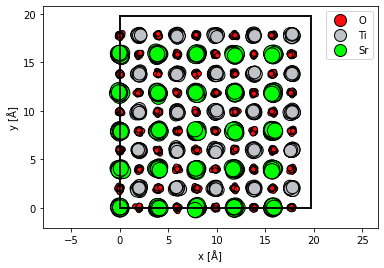

In [4]:
atoms_configuration = next(iter(frozen_phonons))

abtem.show_atoms(atoms_configuration, scale=0.4, legend=True);

The `FrozenPhonons` may be used as the `Atoms` to create a `Potential`.

In [5]:
potential_phonons = abtem.Potential(frozen_phonons, gpts=512, slice_thickness=2)
potential_elastic = abtem.Potential(atoms, gpts=512, slice_thickness=2)

If the potential is `build` the resulting `PotentialArray` is represented by a 4d array; an ensemble of $10$ potentials with slightly displaced atomic configurations, each with $99$ slices on a $512\times512$ grid.

In [6]:
potential_phonons.build().shape

(10, 99, 512, 512)

We run a multislice simulation for a plane wave with an energy of $150 \ \mathrm{keV}$, then we run the same simulation without phonons.

In [7]:
initial_waves = abtem.PlaneWave(energy=150e3)

exit_waves_phonons = initial_waves.multislice(potential_phonons).compute()
exit_waves_elastic = initial_waves.multislice(potential_elastic).compute()

[########################################] | 100% Completed | 10.72 s
[########################################] | 100% Completed | 1.96 ss


The output is an ensemble of 10 exit waves; one for each potential in the frozen phonon ensemble.

In [8]:
exit_waves_phonons.shape

(10, 512, 512)

We show the intensity of the one of the exit waves and the average intensity of the thermal ensemble. We observe that while the individual snapshots are noisy, this averages out in the thermal ensemble.

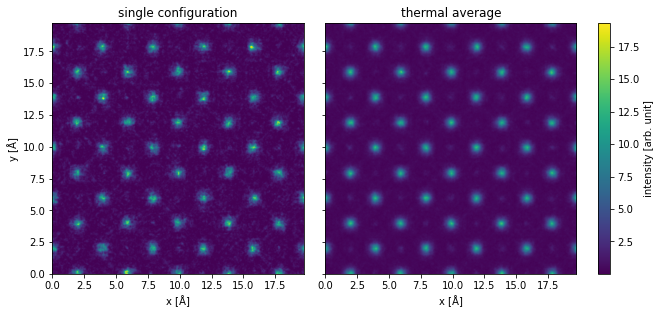

In [9]:
abtem.stack(
    [exit_waves_phonons[0].intensity(), exit_waves_phonons.intensity().mean(0)],
    ("single configuration", "thermal average"),
).show(explode=True, figsize=(10, 6), cbar=True, common_color_scale=True);

Below we show a comparison diffraction patterns for the fully elastic model and the model including frozen phonons, the figures are shown on a common color scale.

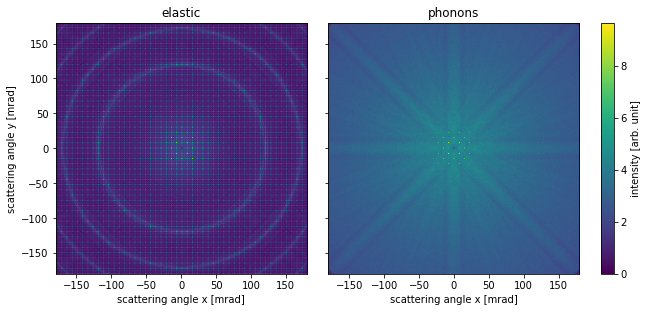

In [10]:
diffraction_patterns_elastic = exit_waves_elastic.diffraction_patterns(
    max_angle="valid", block_direct=True
)
diffraction_patterns_phonons = exit_waves_phonons.diffraction_patterns(
    max_angle="valid", block_direct=True
).mean(0)

diffraction_patterns = abtem.stack(
    [
        diffraction_patterns_elastic,
        diffraction_patterns_phonons,
    ],
    ("elastic", "phonons"),
).show(
    explode=True,
    power=0.1,
    units="mrad",
    figsize=(10, 6),
    cbar=True,
    common_color_scale=True,
);

In the model with phonons the higher order spots are significantly dampened compared to the elastic model. This intensity is instead concentrated in low-order spots and as a diffuse background scattering. The model with phonons also shows visible Kikuchi lines as bands radiating from the center and whereas Laue diffraction rings (also known as HOLZ lines) are significantly dampened.

We tabulate the diffraction spots up 3rd order confirming the above observations.

In [11]:
table_elastic = (
    diffraction_patterns_elastic.crop(25)
    .index_diffraction_spots(cell=3.945)
    .to_dataframe(index="elastic")
)
table_phonons = (
    diffraction_patterns_phonons.crop(25)
    .index_diffraction_spots(cell=3.945)
    .to_dataframe(index="phonons")
)

pd.concat((table_elastic, table_phonons))

,100,110,200,220,310
elastic,57856812.0,5.378259e+09,2.848594e+09,908702976.0,170027984.0
phonons,89862496.0,7.007971e+09,1.176386e+09,215054256.0,265815712.0


## STEM simulation with frozen phonons

While the intensity of higher-order spots are generally dampened by phonons, this is compensated for by high-angle diffuse scattering, thus it is not necessarily obvious how phonon scattering affects STEM simulations with a HAADF detector. 

We create a `Probe` with an energy of $200 \ \mathrm{keV}$ and a convergence semi-angle of $20 \ \mathrm{mrad}$. We create a `LineScan` along the diagonal of a single periodic unit.

In [12]:
probe = abtem.Probe(energy=200e3, semiangle_cutoff=20)

scan = abtem.LineScan.from_fractional_coordinates(
    potential_elastic, start=(0, 0), end=(1 / repetitions[0], 1 / repetitions[1])
)

We create task graph for scanned multislice, stack the resulting `Images` and `compute`.

In [13]:
measurements_phonons = probe.scan(potential_phonons, scan=scan)
measurements_elastic = probe.scan(potential_elastic, scan=scan)

measurements = abtem.stack(
    [measurements_phonons, measurements_elastic], ("phonons", "elastic")
)

measurements.compute();

[########################################] | 100% Completed | 40.45 ss


The `FlexibleAnnularDetector` was used by default, hence we can now choose how the result should be integrated.
Below the fully elastic and phonon models are compared for a BF signal ($[0, 20] \ \mathrm{mrad}$), two MAADF signals ($[50, 100] \ \mathrm{mrad}$ and $[50, 120] \ \mathrm{mrad}$) and HAADF signal ($[80, 200] \ \mathrm{mrad}$).

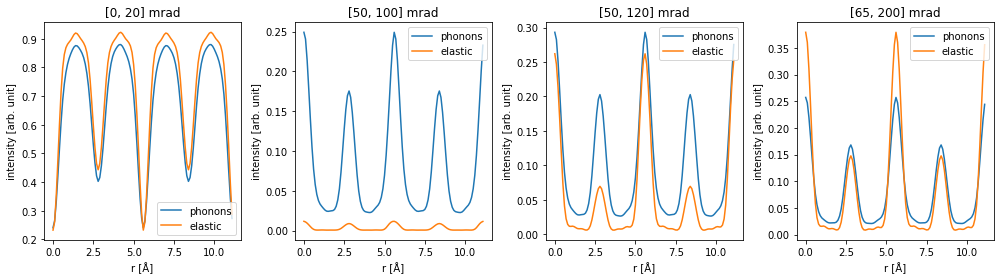

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))
measurements.integrate_radial(inner=0, outer=20).interpolate(0.1).tile(2).show(
    ax=ax1, title="[0, 20] mrad"
)
measurements.integrate_radial(inner=50, outer=100).interpolate(0.1).tile(2).show(
    ax=ax2, title="[50, 100] mrad"
)
measurements.integrate_radial(inner=50, outer=120).interpolate(0.1).tile(2).show(
    ax=ax3, title="[50, 120] mrad"
)
measurements.integrate_radial(inner=65, outer=200).interpolate(0.1).tile(2).show(
    ax=ax4, title="[65, 200] mrad"
)

plt.tight_layout();

The importance of phonon scattering is clearly demonstrated. The scattering in the phonon model is generally stronger, especially the background, however, on a strongly scattering column the elastic model may sometimes scatter more strongly, as seen in the HAADF signal.

Comparing the two MAADF signals, we see how sensitive the elastic model is to the inclusion of the first Laue diffraction ring (at $\sim 110 \ \mathrm{mrad}$) in the integration range.  